# How the Smoother Affect Prediction Results

Import necessary modules: 

In [1]:
import numpy as np
import pandas as pd
from ADRprofilePrediction import Pairs2Mat, evaluation
from Models import loadHyperpar
import matplotlib.pylab as plt

In [2]:
import sklearn
print(sklearn.__version__)

0.24.2


## Load data

Load the feature data, drug-gene interaction (DGI), in to a dictionary. We used the DGI feature as an example to study how the smoother affects the prediction results.

In [3]:
features_dict = {
    "DGI":Pairs2Mat(path="data/interactions.tsv",colname1="drug_claim_name",colname2="gene_name"),
}

Load drug-ADR data from SIDER. Only ADRs with frequency lower than 50 were used.

In [4]:
filter = "rare"
SEs = {}
if filter == "rare":
    SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
    column_sums = np.sum(SIDER, axis=0)
    SEs["SIDER"] = SIDER.loc[:, (column_sums < 50)]

## Set variables

The variables below includes all the options for the code.

- features_names: DGI was used as an example feature.
- SE_names: ADR data from SIDER.
- methods: This option is machine learning methods used for prediction. We studied how smoother affect the performance of SKR, so SKR was chosen.
- metrice_names: Metric we used to evaluate the performance of methods: AUPR, AUROC, AUPR per drug, AUROC per drug, AUPR+AUROC and AUPR+AUROC per drug.
- SE_name: The used ADR data in this file.
- metric: We used AUPR as the tuning metrice in Nested CV and CV.

In [5]:
features_names = ["DGI"]
methods = ["SKR"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
SEs_name = "SIDER"
metrice = "AUPR"

## Evaluate the Prediction of Rare ADRs under Different Strengthen of Smoother

In [9]:
results={}
for c in np.arange(0, 1, 0.1):
    method = "SKR"
    validation = "nested_cv"
    # Use the tuned hyperpars for each fold with only c changed
    hyperpars = [
    (0.01, c, 10, 100),
    (0.01, c, 10, 100),
    (0.01, c, 10, 100),
    (0.01, c, 10, 100),
    (0.01, c, 10, 100),
    ]
    str = "DGI"
    print(f"using feature {str}")
    results[c], _ = evaluation(Y=SEs["SIDER"], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparfixed=hyperpars,Validation=validation,n_jobs=1)
    

using feature DGI
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  1
first few training idx:  [ 78 305 355 378 498 546 622 647 680 723]
first few testing idx:  [139 282 369 438 510 565 659 676 684 726]
--- tuning end ---
target size: 146
------ best hyper pars:  (0.01, 0.0, 10, 100) ------
SKR starts:
SKR ends:
-----------
AUPRperdrug: 0.0980159498998838
AUROCperdrug: 0.6857177362102246
AUPR+AUROCperdrug: 0.7837336861101084
AUPR: 0.0572340587597667
AUROC: 0.6555702806727252
AUPR+AUROC: 0.7128043394324919
-----------
Fold: 1
number of hyperpars combination:  1
first few training idx:  [139 282 369 438 510 565 659 676 684 726]
first few testing idx:  [ 78 305 355 378 498 546 622 647 680 723]
--- tuning end ---
target size: 146
------ best hyper pars:  (0.01, 0.0, 10, 100) ------
SKR starts:
SKR ends:
-----------
AUPRperdrug: 0.0920543745498983
AUROCperdrug: 0.672560575996625
AUPR+AUROCperdrug: 0.7646149505465233
AUPR: 0.06370695905467466
AUROC: 0.6398300935

AUROC and AUROC per drug

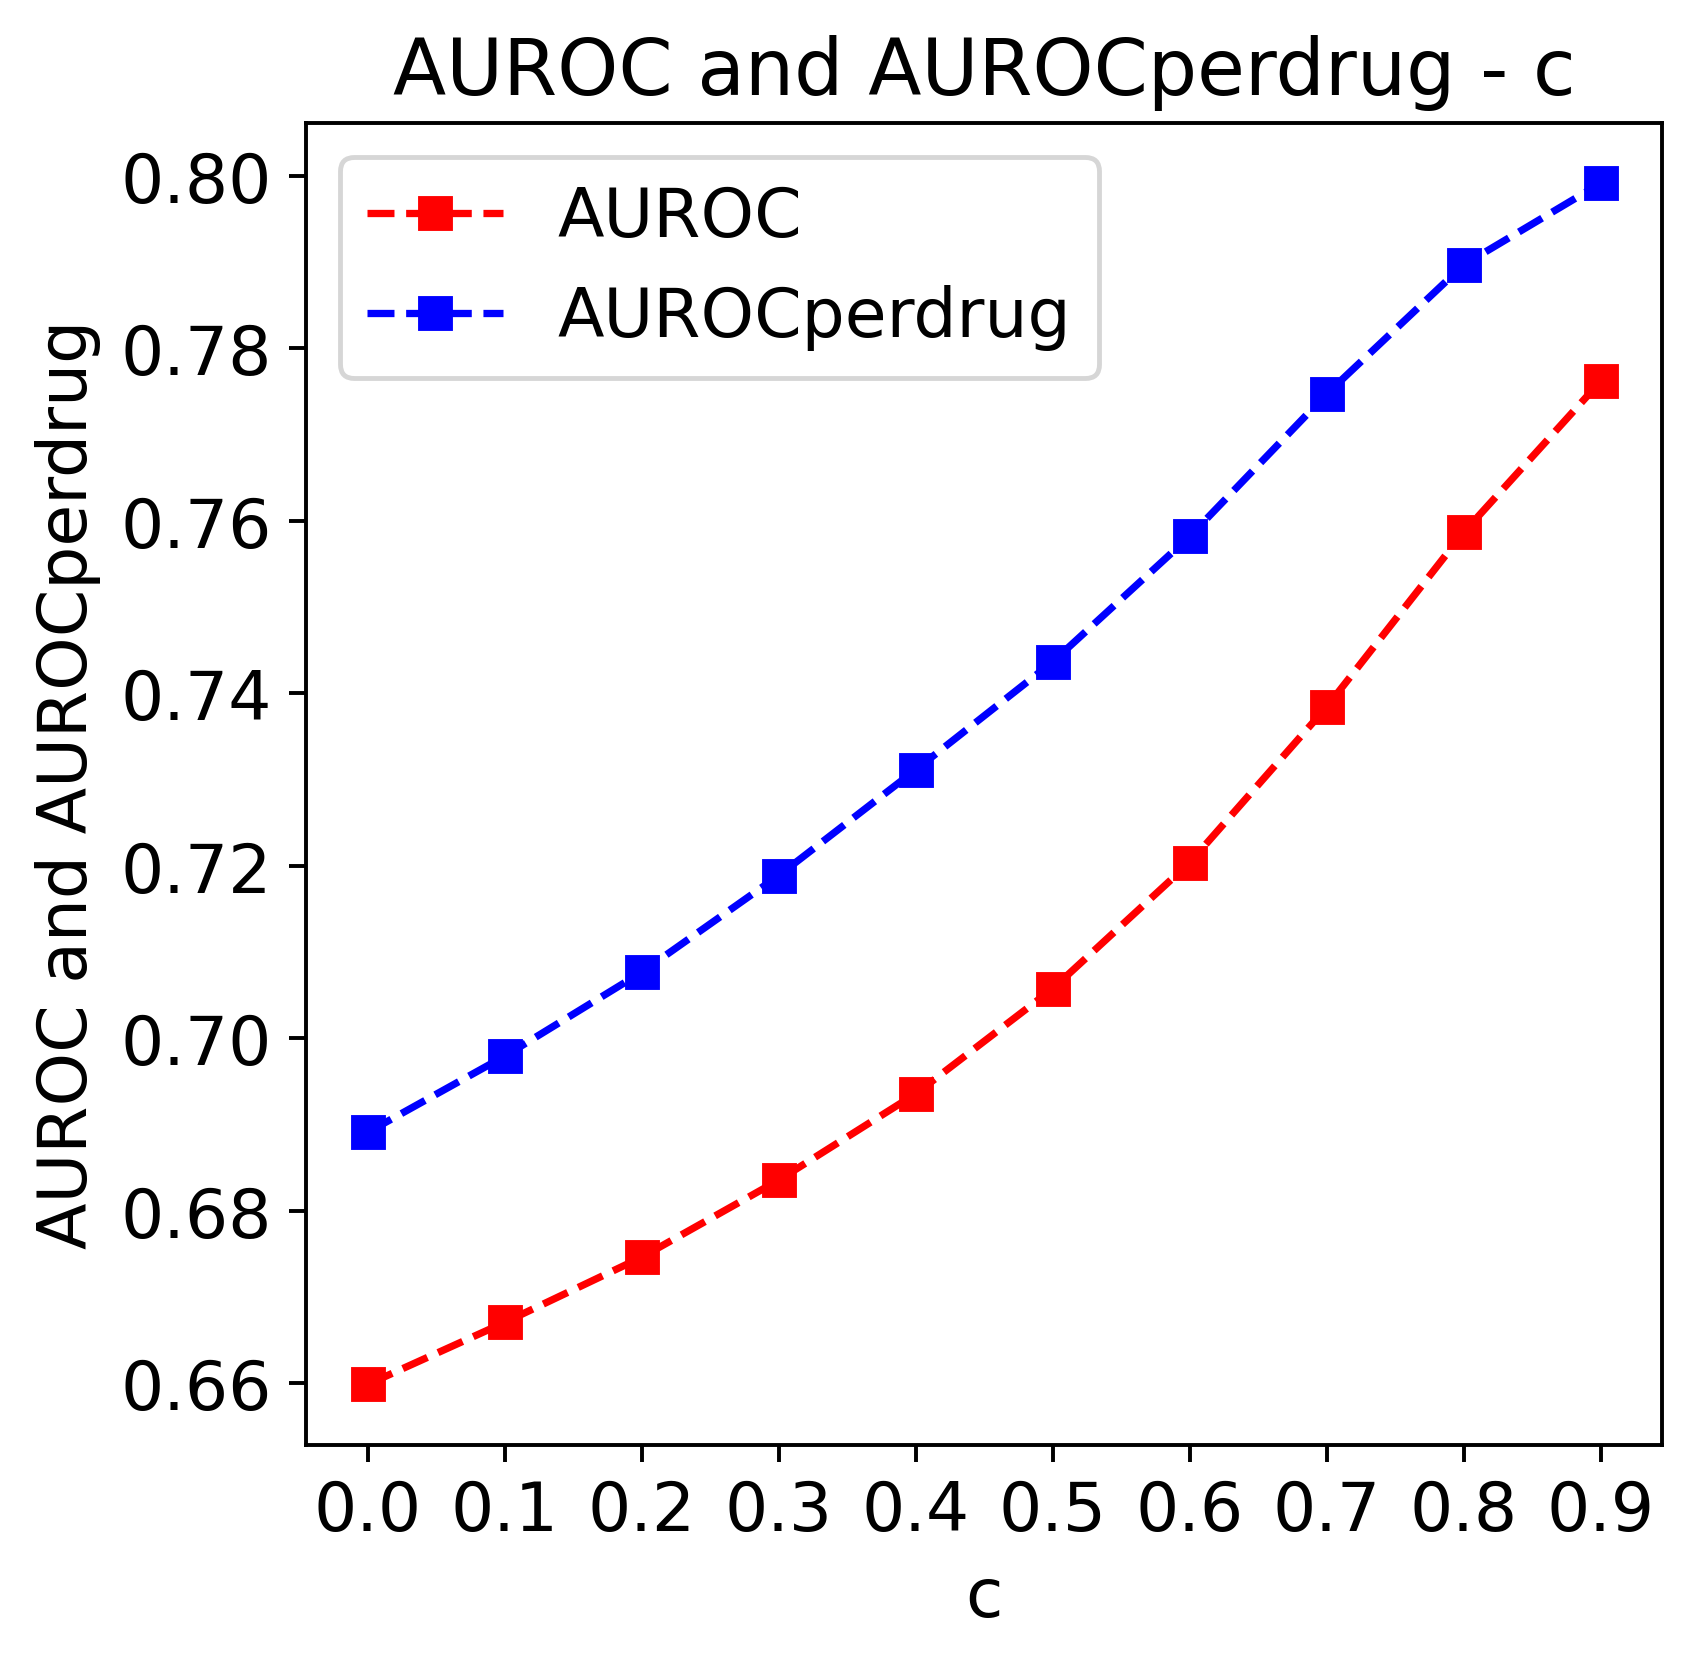

In [39]:
plt.figure(figsize=(5,5), dpi=350)
df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUROC"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='r', label='AUROC')

df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUROCperdrug"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='b', label='AUROCperdrug')


xt = plt.xticks(np.arange(0, 10), np.arange(0, 1, 0.1).round(1),fontsize=14)
# Add a legend
plt.legend(fontsize=14)
plt.title("AUROC and AUROCperdrug - c",fontsize=16)
# Show the plot
plt.xlabel('c',fontsize=14)
plt.ylabel('AUROC and AUROCperdrug',fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig(fname=f"figs/AUROC-C.jpg", bbox_inches="tight")
plt.show()

AUPR and AUPR per drug

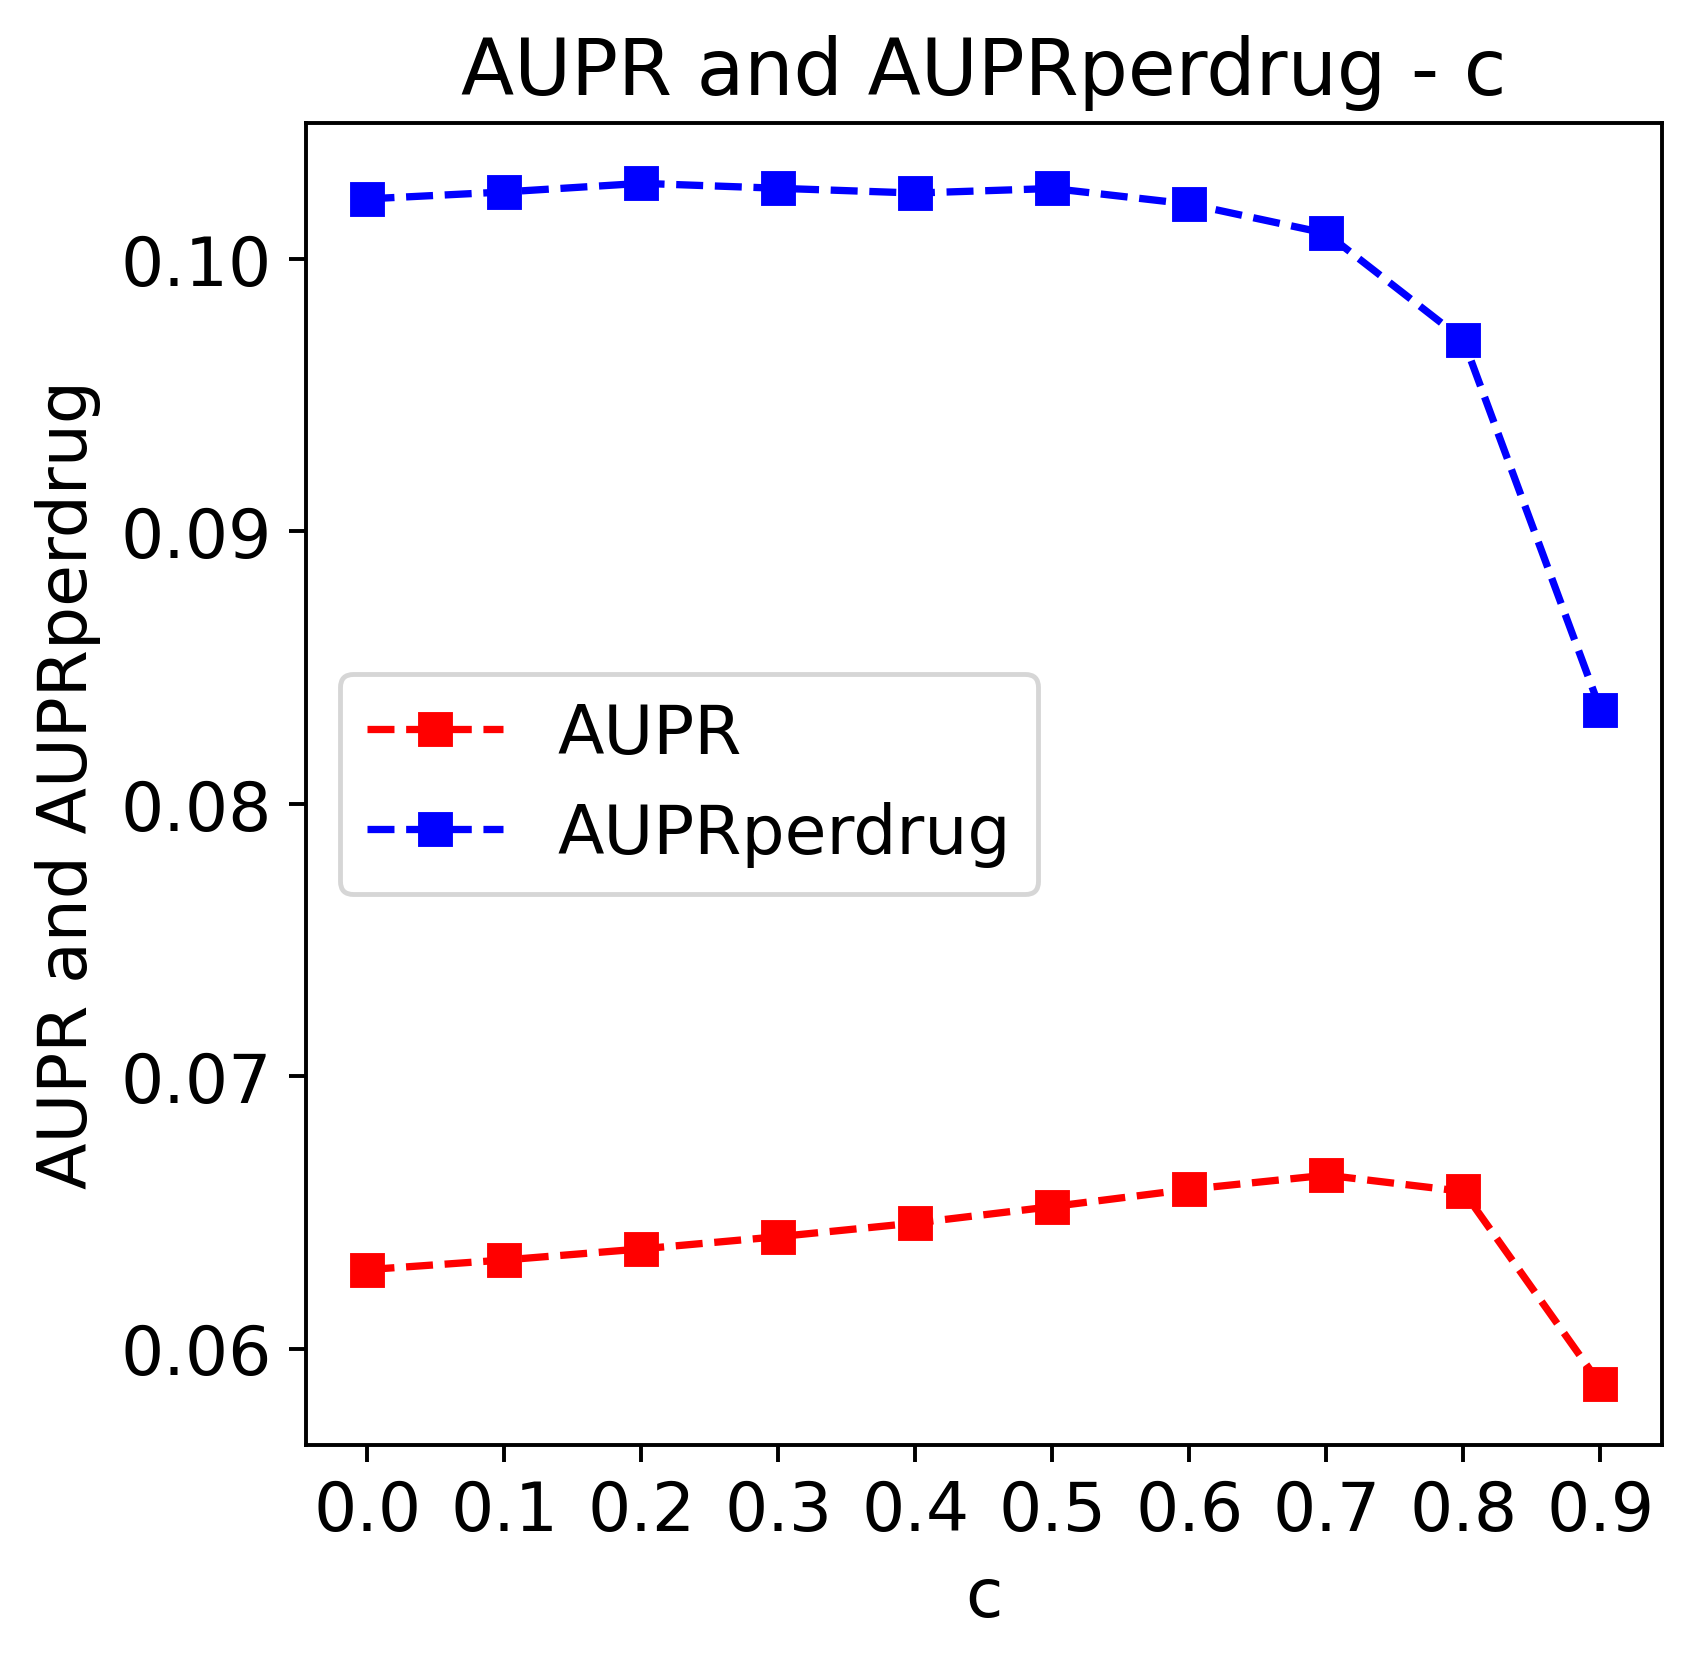

In [40]:
plt.figure(figsize=(5,5), dpi=350)
df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUPR"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='r', label='AUPR')

df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUPRperdrug"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='b', label='AUPRperdrug')


xt = plt.xticks(np.arange(0, 10), np.arange(0, 1, 0.1).round(1), fontsize=14)
# Add a legend
plt.legend(fontsize=14)
plt.title("AUPR and AUPRperdrug - c", fontsize=16)
plt.xlabel('c', fontsize=14)
plt.ylabel('AUPR and AUPRperdrug', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig(fname=f"figs/AUPR-C.jpg", bbox_inches="tight")
# Show the plot
plt.show()

AUPR+AUROC and AUPR+AUROC per drug

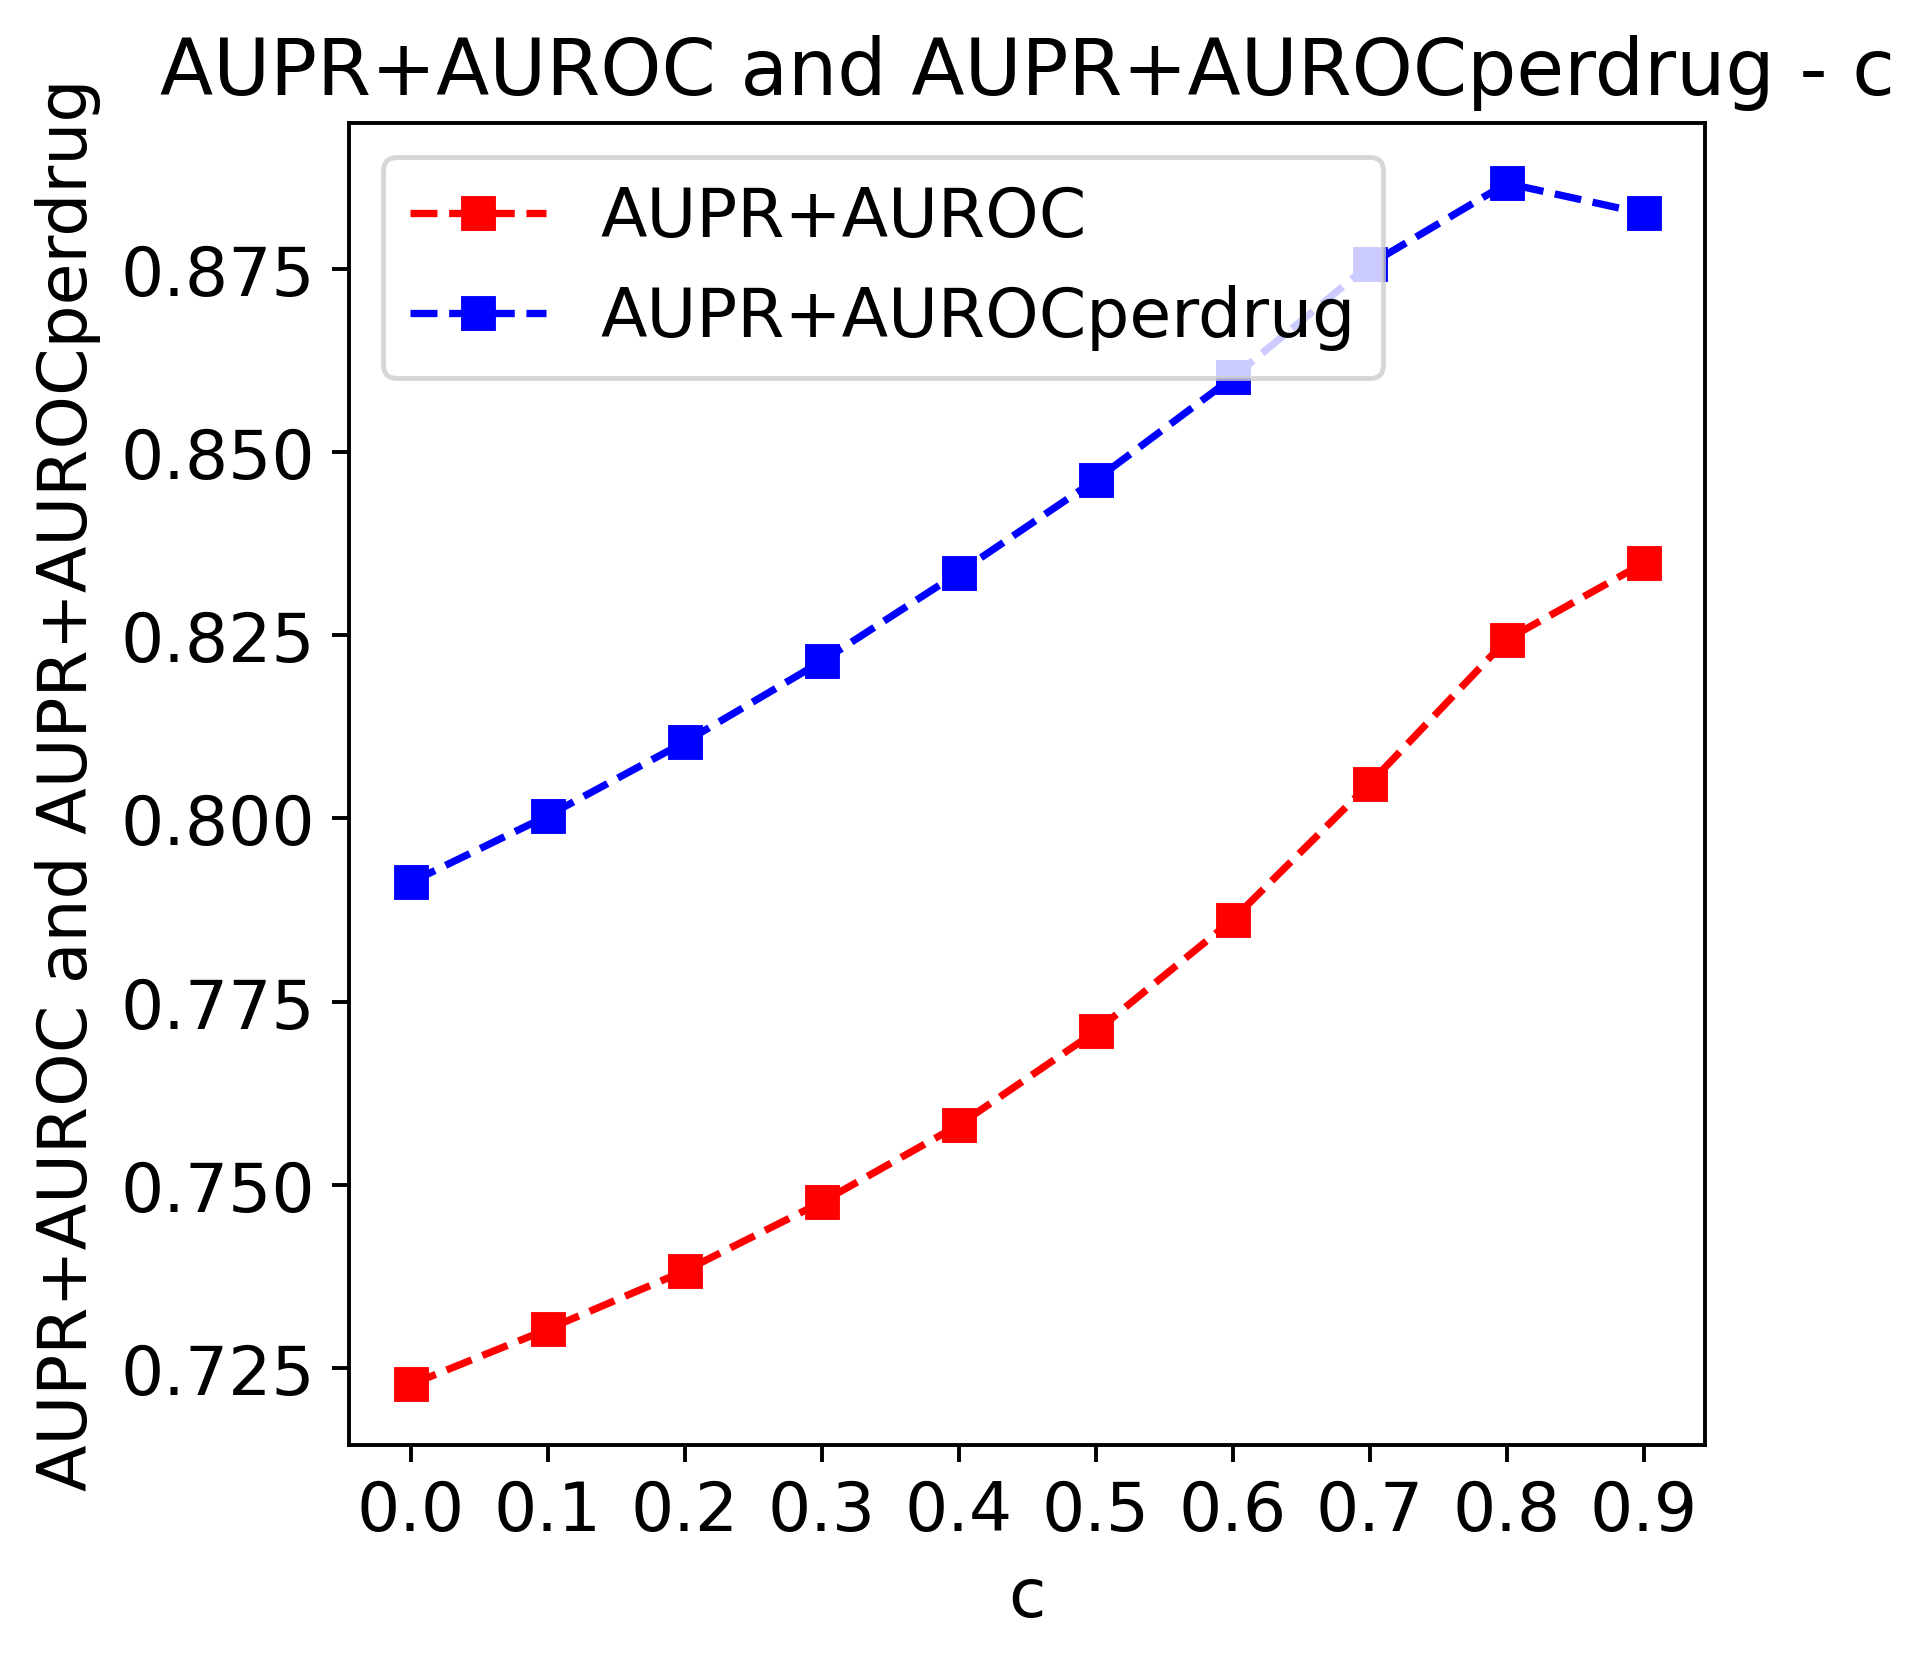

In [41]:
plt.figure(figsize=(5,5), dpi=350)
df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUPR+AUROC"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='r', label='AUPR+AUROC')

df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUPR+AUROCperdrug"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='b', label='AUPR+AUROCperdrug')


xt = plt.xticks(np.arange(0, 10), np.arange(0, 1, 0.1).round(1),fontsize=14)
# Add a legend
plt.legend(fontsize=14)
plt.title("AUPR+AUROC and AUPR+AUROCperdrug - c",fontsize=16)
plt.xlabel('c',fontsize=14)
plt.ylabel('AUPR+AUROC and AUPR+AUROCperdrug',fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig(fname=f"figs/AUPR+AUROC-C.jpg", bbox_inches="tight")
# Show the plot
plt.show()